In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [54]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [55]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [56]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)


  0%|          | 1354/312735 [00:00<00:23, 13535.20it/s]

Processing text dataset


100%|██████████| 312735/312735 [00:19<00:00, 15936.37it/s]


In [57]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 365516 unique tokens


In [58]:
from gensim.models import Word2Vec

In [59]:
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=16, sg=0, negative=5)

In [60]:
word_vectors = model.wv

In [61]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 70056


In [62]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('prince', 0.9737831950187683),
 ('princess', 0.9697957038879395),
 ('queen', 0.9612919092178345),
 ('mary', 0.9477518200874329),
 ('bishop', 0.9473669528961182),
 ('duchess', 0.9413490295410156),
 ('mayor', 0.9313793182373047),
 ('pope', 0.9309110045433044),
 ('abraham', 0.9138915538787842),
 ('emperor', 0.9105724692344666)]

In [63]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [75]:
from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 1)
Shape of test_data tensor: (153164, 200)


In [76]:
from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 200)


In [77]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

In [78]:
import tensorflow as tf

In [79]:
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate


def attention_3d_block(hidden_states):
    """
    Many-to-one attention mechanism for Keras.
    @param hidden_states: 3D tensor with shape (batch_size, time_steps, input_dim).
    @return: 2D tensor with shape (batch_size, 128)
    @author: felixhao28.
    """
    hidden_size = int(hidden_states.shape[2])
    # Inside dense layer
    #              hidden_states            dot               W            =>           score_first_part
    # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    # W is the trainable weight matrix of attention Luong's multiplicative style score
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    #            score_first_part           dot        last_hidden_state     => attention_weights
    # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [80]:
wv_layer = tf.keras.layers.Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = tf.keras.layers.SpatialDropout1D(0.2)(embedded_sequences)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded_sequences)
x = attention_3d_block(x)
# Output
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
preds = tf.keras.layers.Dense(6, activation='sigmoid')(x)

# build the model
model = tf.keras.models.Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['accuracy'])

In [81]:
hist = model.fit([data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 335s 2ms/sample - loss: 0.1638 - accuracy: 0.9430 - val_loss: 0.0513 - val_accuracy: 0.9811
Epoch 2/10
143613/143613 [==============================] - 356s 2ms/sample - loss: 0.0522 - accuracy: 0.9810 - val_loss: 0.0465 - val_accuracy: 0.9822
Epoch 3/10
143613/143613 [==============================] - 361s 3ms/sample - loss: 0.0476 - accuracy: 0.9822 - val_loss: 0.0465 - val_accuracy: 0.9818
Epoch 4/10
143613/143613 [==============================] - 346s 2ms/sample - loss: 0.0450 - accuracy: 0.9830 - val_loss: 0.0439 - val_accuracy: 0.9834
Epoch 5/10
143613/143613 [==============================] - 341s 2ms/sample - loss: 0.0434 - accuracy: 0.9835 - val_loss: 0.0448 - val_accuracy: 0.9826
Epoch 6/10
143613/143613 [==============================] - 342s 2ms/sample - loss: 0.0422 - accuracy: 0.9838 - val_loss: 0.0441 - val_accuracy: 0.9829
Epoch 7/10
143613/143613 [===========

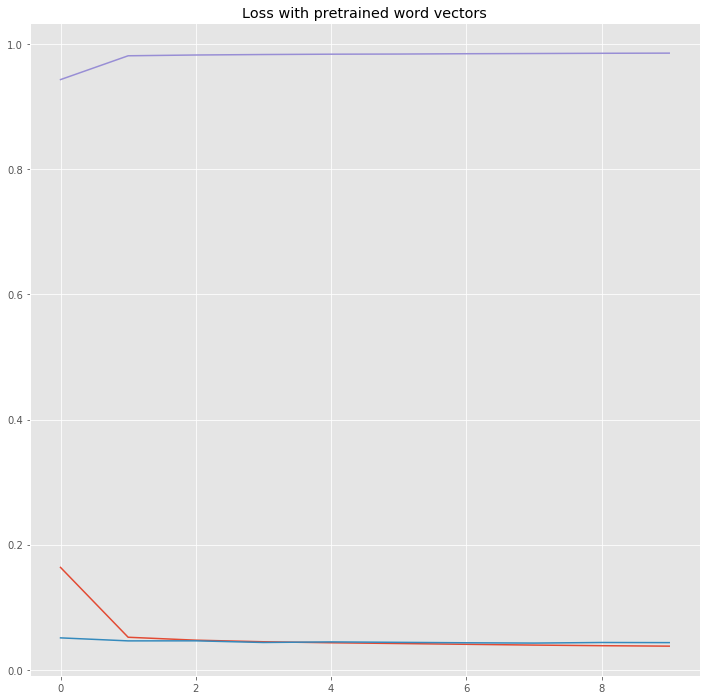

In [83]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.plot(history["accuracy"]);
plt.title("Loss with pretrained word vectors");
plt.show();

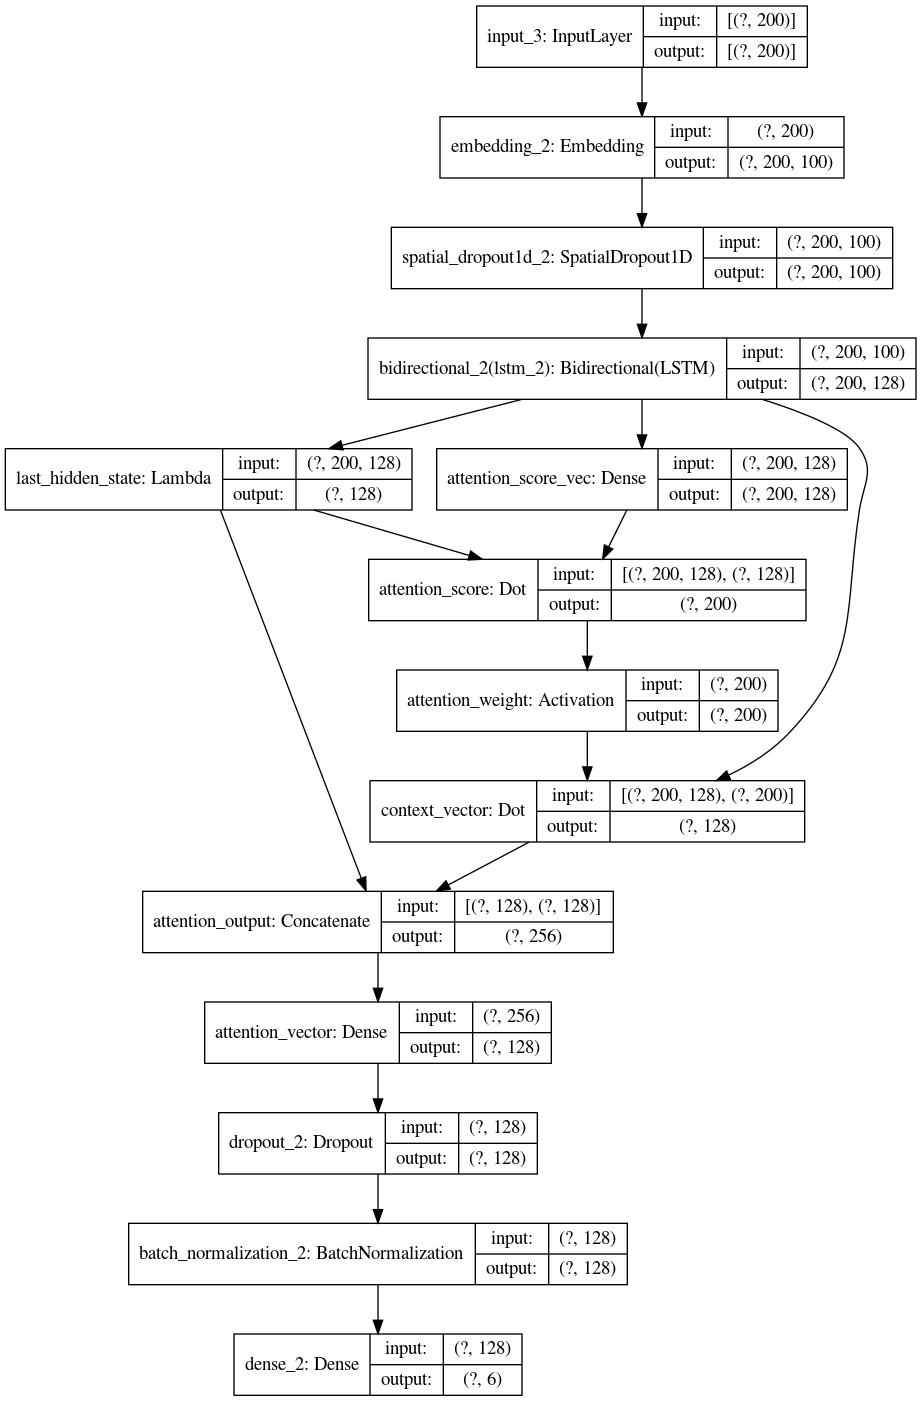

In [84]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)